In [1]:
%load_ext autoreload
%autoreload 2
import copy
import gc
import sys

sys.path.append('..')

import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                     cross_val_score)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import LGBMRegressor

from src.utils.cross_validation import TimeSeriesGroupSplit
from src.utils.downcasting import downcast_dtypes

sns.set(font_scale=1.2)
%matplotlib inline

In [2]:
max_text_features = 20
random_state = 42

BEST_CONSTANT = 0.2839
MEAN_CONSTANT = 0.3343

# LightGBM

In this notebook we will produce predictions by LightGBM.

## Preparing datasets

In this section we will load all datasets and prepare them for training.

In [3]:
sales_train = pd.read_csv('../data/processed/sales_train.csv')
train = pd.read_hdf('../data/processed/train.h5', 'table')
train = downcast_dtypes(train, from_bytes=32, to_bytes=16)
test = pd.read_hdf('../data/processed/test.h5', 'table')
test = downcast_dtypes(test, from_bytes=32, to_bytes=16)

items = pd.read_csv('../data/processed/items.csv')
tfidf_truncated_svd = pd.read_hdf('../data/processed/text/tfidf_truncated-svd.h5', 'table')

### Adding text features

In [4]:
tfidf_truncated_svd = tfidf_truncated_svd[tfidf_truncated_svd.columns[:max_text_features]]

In [5]:
tfidf_truncated_svd['item_id'] = items.item_id

In [6]:
train = pd.merge(
    train,
    tfidf_truncated_svd,
    how='left', on='item_id'
)

test = pd.merge(
    test,
    tfidf_truncated_svd,
    how='left', on='item_id'
)

gc.collect();

### Clipping target

According to evaluation, target will be clipped between 0 and 20. Let's do it in our dataset.

In [7]:
train.target = np.clip(train.target, 0, 20)

### Process categorical data

Find categorical columns.

In [8]:
categorical_types = ['object', 'bool']

In [9]:
train.dtypes[np.isin(train.dtypes.values, categorical_types)]

item_name                  object
item_in_test                 bool
item_full_category_name    object
item_category_name         object
item_subcategory_name      object
shop_name                  object
city                       object
shop_in_test                 bool
dtype: object

Don't touch boolean objects, they are already label encoded.

Let's remove columns `item_name`, `shop_name`, because we already have them label encoded as `item_id`, `shop_id`.

In [10]:
train.drop(columns=['item_name', 'shop_name'], inplace=True)
test.drop(columns=['item_name', 'shop_name'], inplace=True)

Let's define list with all categorical values.

In [11]:
categorical_features = [
    'month', 'item_id', 'item_full_category_name', 'item_category_name', 
    'item_subcategory_name', 'shop_id', 'city'
]

#### Label encoding

We will label encode only `city`, because in other cases we have already label encoded features or there are values on test, that are not present on train.

In [12]:
label_encode_features = ['city']

for column in label_encode_features:
    le = LabelEncoder()
    
    encoded_feature_train = le.fit_transform(train[column])
    train[f'{column}_labeled'] = encoded_feature_train
    
    encoded_feature_test = le.transform(test[column])
    test[f'{column}_labeled'] = encoded_feature_test

#### Mean encoding

In [13]:
for column in tqdm(categorical_features):
    # encode train
    cumsum = train.groupby(column).target.cumsum() - train.target
    cumcount = train.groupby(column).cumcount()
    encoded_feature = cumsum / cumcount
    encoded_feature.fillna(MEAN_CONSTANT, inplace=True)
    
    train[f'{column}_mean_encoded_mean'] = encoded_feature
    
    # encode test
    mean_train = train.groupby(column).target.mean()
    test[f'{column}_mean_encoded_mean'] = test[column].map(mean_train).fillna(MEAN_CONSTANT)

Drop all redundant columns.

In [14]:
to_drop = ['item_id', 'item_full_category_name', 'item_category_name', 
           'item_subcategory_name', 'city']
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)

### Processing NaNs

Fill NaNs.

In [15]:
train.columns[train.isna().sum() > 0]

Index(['num_residents'], dtype='object')

As we expected there are some problems only with `num_residents`. We can fill it with zero, because it will be border value for this feature, trees can handle it properly.

In [16]:
train.fillna(0, inplace=True)

### Removing target

Remove target from train.

In [17]:
y = train.target
train.drop(columns=['target'], inplace=True)

### Create validation split.

Let's also delete from train rows that appears only on validation, it will make our train/validation split more consistant with train/test split.

In [18]:
X_valid = train[train.date_block_num == 33]
X_train = train[train.date_block_num < 33]
y_valid = y[train.date_block_num == 33]
y_train = y[train.date_block_num < 33]
X_test = test
    
del train, test
gc.collect()

3

## Grid search

In this section we will find optimum parameters for a model. Firstly, fix the result before any optimization.

In [19]:
ts = TimeSeriesGroupSplit(n_splits=5, max_train_size=int(2*10**5))

lgb_params = {
    'objective': 'rmse',
    'learning_rate': 0.1,
    'random_state': random_state
}

In [20]:
default_score = cross_val_score(
    LGBMRegressor(**lgb_params), 
    X_train, y_train, groups=X_train.date_block_num,
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=0,
    cv=ts
).mean()
print(f'Current score: {-default_score:.5f}')

Current score: 0.94464


Score: $0.94464$.

### `n_estimators`

In this section we fix `learning_rate = 0.1` and try to find reasonable num of iterations. Try with cv method in lightgbm failed because of RAM. Thus I will simply run grid search.

In [22]:
param_grid = {
    'n_estimators': np.arange(50, 301, 50)
}

gs = GridSearchCV(
    LGBMRegressor(**lgb_params), 
    param_grid,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts
)

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.cv_results_

gs.best_params_

In [23]:
lgb_params['n_estimators'] = 83

### Tree parameters

Here we will find optimum values for building tree:
* `num_leaves`
* `max_depth`
* `min_data_in_leaf`

In [24]:
param_distributions = {
    'num_leaves': sps.randint(low=10, high=100),
    'max_depth': [-1] + np.arange(5, 16),
    'min_data_in_leaf': sps.logser(1-10**(-4), loc=9),
}

gs = RandomizedSearchCV(
    LGBMRegressor(**lgb_params), 
    param_distributions,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts, 
    n_iter=80,
    random_state=random_state
)

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.best_params_

gs.best_score_

May be will be better to take default values.

In [25]:
lgb_params['max_depth'] = 4
lgb_params['min_data_in_leaf'] = 183
lgb_params['num_leaves'] = 68

### Subsampling

Here we will find optimum parameters for subsampling:
* `bagging_fraction`
* `feature_fraction`

In [26]:
param_grid = {
    'bagging_fraction': np.linspace(0.2, 1, 5),
    'feature_fraction': np.linspace(0.2, 1, 5)
}

gs = GridSearchCV(
    LGBMRegressor(**lgb_params), 
    param_grid,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts
)

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.best_params_

gs.cv_results_

gs.best_score_

In [27]:
lgb_params['bagging_fraction'] = 1.0
lgb_params['feature_fraction'] = 1.0

### Regularization

In [28]:
lgb_params

{'objective': 'rmse',
 'learning_rate': 0.1,
 'random_state': 42,
 'n_estimators': 83,
 'max_depth': 4,
 'min_data_in_leaf': 183,
 'num_leaves': 68,
 'bagging_fraction': 1.0,
 'feature_fraction': 1.0}

Here we will find optimum parameters for regularization:
* `lambda_l1`
* `lambda_l2`

In [29]:
param_grid = {
    'lambda_l1': [0, 10**(-2), 10**(-1), 1, 10],
    'lambda_l2': [0, 10**(-2), 10**(-1), 1, 10]
}

gs = GridSearchCV(
    LGBMRegressor(**lgb_params), 
    param_grid,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts
)

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.best_params_

gs.best_score_

gs.cv_results_

In [30]:
lgb_params['lambda_l1'] = 0.01
lgb_params['lambda_l2'] = 0.01

### Reduce learning rate

Current score:

In [31]:
current_score = cross_val_score(
    LGBMRegressor(**lgb_params), 
    X_train, y_train, groups=X_train.date_block_num,
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=0,
    cv=ts
).mean()
print(f'Current score: {-current_score:.5f}')

Score: $0.93146$.

Now we can half our `learning rate` and double `num_iterations`.

In [32]:
lgb_params_changed = copy.copy(lgb_params)
lgb_params_changed['learning_rate'] /= 2
lgb_params_changed['n_estimators'] = int(lgb_params['n_estimators'] * 2)

In [33]:
score_after_change = cross_val_score(
    LGBMRegressor(**lgb_params_changed), 
    X_train, y_train, groups=X_train.date_block_num,
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=0,
    cv=ts
).mean()

print(f'Score after changing: {-score_after_change:.5f}')

Score: $0.93271$.

It didn't helped. Best parameters:

In [34]:
lgb_params

{'objective': 'rmse',
 'learning_rate': 0.1,
 'random_state': 42,
 'n_estimators': 83,
 'max_depth': 4,
 'min_data_in_leaf': 183,
 'num_leaves': 68,
 'bagging_fraction': 1.0,
 'feature_fraction': 1.0,
 'lambda_l1': 0.01,
 'lambda_l2': 0.01}

## Validation

In this section we will validate best parameters using haldout. We will use not all train, because of limitation of RAM.

In [35]:
(X_train.date_block_num >= 25).sum()

1627417

In [36]:
start_date_block_num = 25
indices_train = (X_train.date_block_num >= start_date_block_num)
X_train = X_train[indices_train]
y_train = y_train[indices_train]
gc.collect();

In [37]:
model = LGBMRegressor(**lgb_params)
model.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=1.0, feature_fraction=1.0, lambda_l1=0.01,
              lambda_l2=0.01, max_depth=4, min_data_in_leaf=183,
              n_estimators=83, num_leaves=68, objective='rmse',
              random_state=42)

In [38]:
y_predicted = np.clip(model.predict(X_valid), 0, 20)
validation_score = mean_squared_error(y_valid, y_predicted)
print(f'Validation score: {validation_score:.5f}')

Validation score: 0.86274


Score: $0.86274$

### Some validation results


#### Text features 

Changing cleaning / stemming:
1. no cleaning, no stemming, `ngram_range=(1, 2)`, `max_df=0.5`, $0.82570$
2. cleaning, no stemming, `ngram_range=(1, 2)`, `max_df=0.5`, $0.83072$
3. cleaning, stemming, `ngram_range=(1, 2)`, `max_df=0.5`, $0.82774$
4. cleaning, no stemming, `ngram_range=(1, 1)`, `max_df=1.0`, $0.82450$
5. no cleaning, no stemming, `ngram_range=(1, 1)`, `max_df=1.0`, $0.82928$

Changing `max_df`:
1. cleaning, stemming, `ngram_range=(1, 1)`, `max_df=1.0`, $0.82561$
2. cleaning, stemming, `ngram_range=(1, 1)`, `max_df=0.5`, $0.82561$

Changing `ngram_range`:
1. cleaning, stemming, `ngram_range=(1, 2)`, `max_df=1.0`, $0.82774$
2. cleaning, stemming, `ngram_range=(1, 3)`, `max_df=1.0`, $0.83526$

It was decided to use: cleaning, no stemming, `ngram_range=(1, 1)`, `max_df=1.0`.

Changing dimensions:
1. `res_dim=50`, `max_text_features=20`, $0.82450$
2. `res_dim=1`, `max_text_features=1`, $0.81896$
3. `res_dim=3`, `max_text_features=3`, $0.81777$
4. `res_dim=5`, `max_text_features=5`, $0.81956$
5. `res_dim=10`, `max_text_features=10`, $0.82406$
6. `res_dim=20`, `max_text_features=20`, $0.82431$
7. `res_dim=30`, `max_text_features=30`, $0.83380$

It was decided to use `res_dim=3`, `max_text_features=3`.

This results doesn't result in improving public LB score.

Let's look at predicted values charasteristics.

In [39]:
pd.Series(y_predicted).describe()

count    168139.000000
mean          0.374750
std           0.929458
min           0.000000
25%           0.053467
50%           0.150965
75%           0.345521
max          20.000000
dtype: float64

Let's look at feature importances.

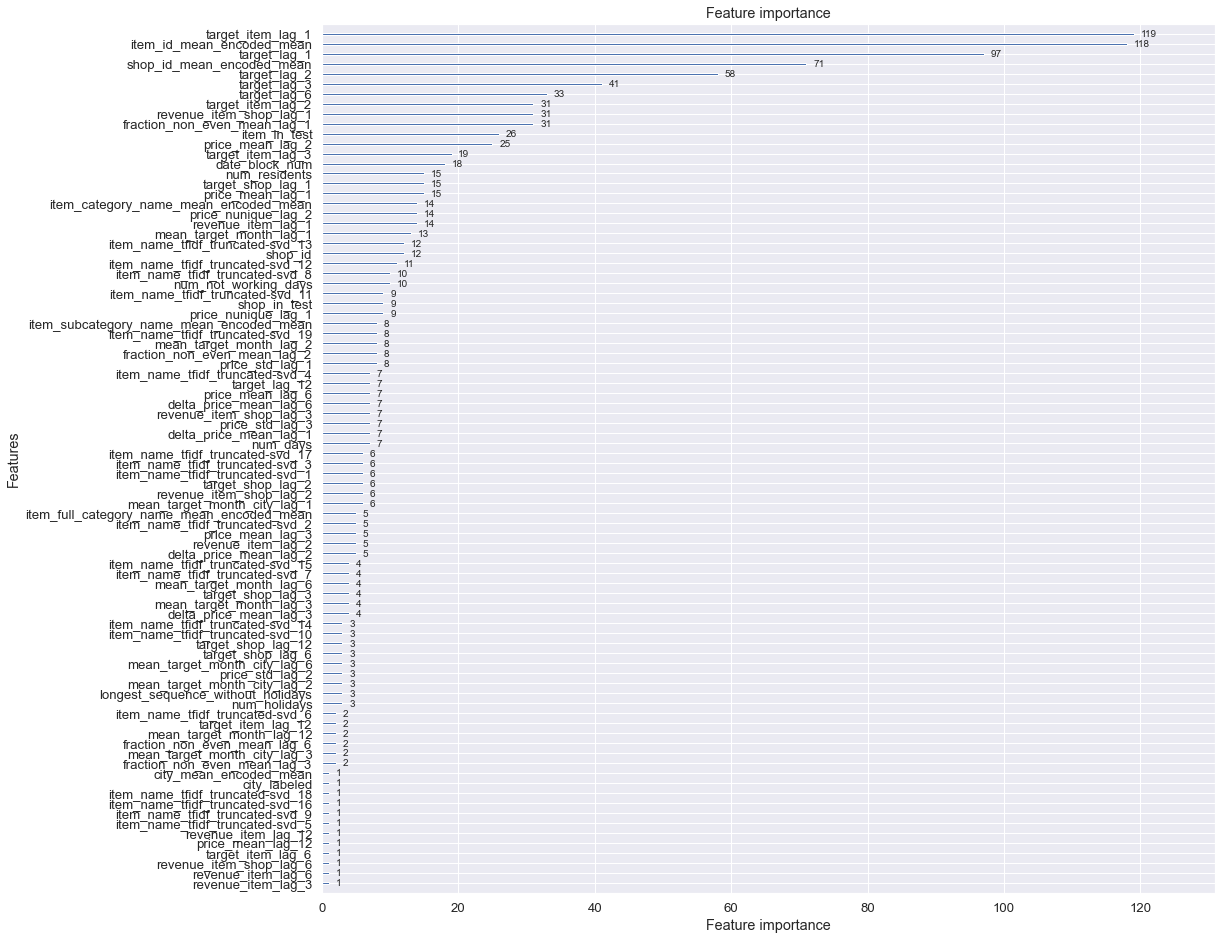

In [40]:
lgb.plot_importance(model.booster_, figsize=(16, 16));

## Submit

In this section we will train result model and submit prediction. Don't forget to clip values according to [evaluation tab](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/evaluation) (but ay be for tree-based methods it is not necessary).

In [43]:
X_train = pd.concat((X_train, X_valid))
y_train = pd.concat((y_train, y_valid))
gc.collect();

In [44]:
X_train.shape

(1795556, 109)

In [45]:
start_date_block_num = 25
indices_train = (X_train.date_block_num >= start_date_block_num)
X_train = X_train[indices_train]
y_train = y_train[indices_train]
gc.collect();

In [46]:
model = LGBMRegressor(**lgb_params)
bags = 10

bagged_predictions = np.zeros(X_test.shape[0])
for n in tqdm(range(bags)):
    model.set_params(random_state=random_state+n)
    model.fit(X_train, y_train)
    bagged_predictions += np.clip(model.predict(X_test), 0, 20)
    gc.collect()
    
bagged_predictions /= bags

Create submission.

In [47]:
pd.Series(bagged_predictions).describe()

count    214200.000000
mean          0.376430
std           0.690604
min           0.000000
25%           0.130632
50%           0.230291
75%           0.381781
max          20.000000
dtype: float64

In [48]:
submission = pd.read_csv('../data/raw/sample_submission.csv')
submission['item_cnt_month'] = bagged_predictions
submission.to_csv('../models/lgb/submission.csv', index=False)

!kaggle competitions submit competitive-data-science-predict-future-sales -f ../models/lgb/submission.csv -m "LightGBM"

Result is $1.00701$. It is pretty far from top positions.

## OOF predictions

In this section we will create out-of-fold predictions for stacking.